# CNN

In [1]:
import os, random, time
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

from utilities import *

# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
# Torchvision library
from torchvision import transforms

from sklearn.model_selection import train_test_split
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from torchsummary import summary


In [11]:
batch_size = 256
N_EPOCHS = 1

In [2]:
# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
   device = torch.device('mps')
else:
    device = torch.device('cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

mps


In [3]:
def set_seed(seed, use_cuda = True, use_mps = False):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    if use_mps:
        torch.mps.manual_seed(seed)

SEED = 44

USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available(), torch.backends.mps.is_available())

# MRI Slice Inputs

In [4]:
class BraTSDataset(Dataset):
    def __init__(self, image_path = r'./BraTS/BraTS2021_Training_Data', transform=None):
        'Initialisation'
        self.image_path = image_path
        self.folders_name = [folder for folder in os.listdir(self.image_path) if folder != '.DS_Store']
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.folders_name) * 155

    def __getitem__(self, index):
        'Generates one sample of data'

        # Determine the image index and the RGB layer
        image_idx = index // 155
        layer_idx = index % 155

        # Select sample
        fld_name = self.folders_name[image_idx]
        image = []
        for scan_type in ['flair', 't1ce', 't2']:
            path_img = os.path.join(self.image_path, fld_name, fld_name + '_' + scan_type + '.nii.gz')
            img = nib.load(path_img).get_fdata()
            # Need to apply standardisation here...
            image.append(img[:, :, layer_idx])
        
        image = np.array(image)

        path_label = os.path.join(self.image_path, fld_name, fld_name + '_seg.nii.gz')

        label = nib.load(path_label).get_fdata()[:, :, layer_idx]
        
        if self.transform:
            image, label = self.transform([image, label])
        return image, label

In [6]:
class everythirdlayer(object):
    def __call__(self, sample):
        image, label = sample
        new_image = image[:,:,:,np.arange(3, 152, 3)]
        new_label = label[:,:,np.arange(3, 152, 3)]
        return new_image, new_label

class Flair(object):
    def __call__(self, sample):
        image, label = sample
        new_image = image[0]
        return new_image, label
    
class IntLabel(object):
    def __call__(self, sample):
        image, label = sample
        new_label = label.astype(int)
        return image, new_label
    
class BinariseLabel(object):
    def __call__(self, sample):
        image, label = sample
        new_label = np.sign(label)
        return image, new_label

class CropAndResize(object):
    def __call__(self, sample):
        image, label = sample
        rows = np.any(image, axis=1)
        cols = np.any(image, axis=0)

        # Find the bounding box of the non-zero regions
        rows_indices = np.where(rows)[0]
        cols_indices = np.where(cols)[0]
        if len(rows_indices) != 0 or len(cols_indices) != 0:
            top_row = np.min(rows_indices)
            bottom_row = np.max(rows_indices)
            left_col = np.min(cols_indices)
            right_col = np.max(cols_indices)

            square_size = max(bottom_row - top_row, right_col - left_col) + 1

            # Crop the image
            cropped_image = image[top_row:top_row + square_size, left_col:left_col + square_size]
            cropped_label = label[top_row:top_row + square_size, left_col:left_col + square_size]
        else:
            cropped_image = image
            cropped_label = label
        # Resize the image
        dim = [64,64]
        resized_image = cv2.resize(cropped_image, dim)
        resized_label = cv2.resize(cropped_label, dim)

        return resized_image, resized_label

class Standardise(object) :
    def __call__(self, sample):
        image, label = sample
        if np.abs(image).sum() == 0:
            return image, label
        with np.errstate(divide='ignore',invalid='ignore'):
            image_no_zeros = np.where(image == 0, np.nan, image)
            new_image = (image_no_zeros - np.nanmean(image_no_zeros)) / np.nanstd(image_no_zeros)
            new_image = np.nan_to_num(new_image)
        return new_image, label

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample
        image = np.float32(image)
        label = np.float32(label)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        # image = image.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(label)

In [7]:
dataset = BraTSDataset(image_path = r'./BraTS/BraTS2021_Training_Data',
                                    transform=transforms.Compose([
                                        Flair(),
                                        CropAndResize(),
                                        Standardise(),
                                        IntLabel(),
                                        BinariseLabel(),
                                        ToTensor()
                                    ]))

# Post processing scans

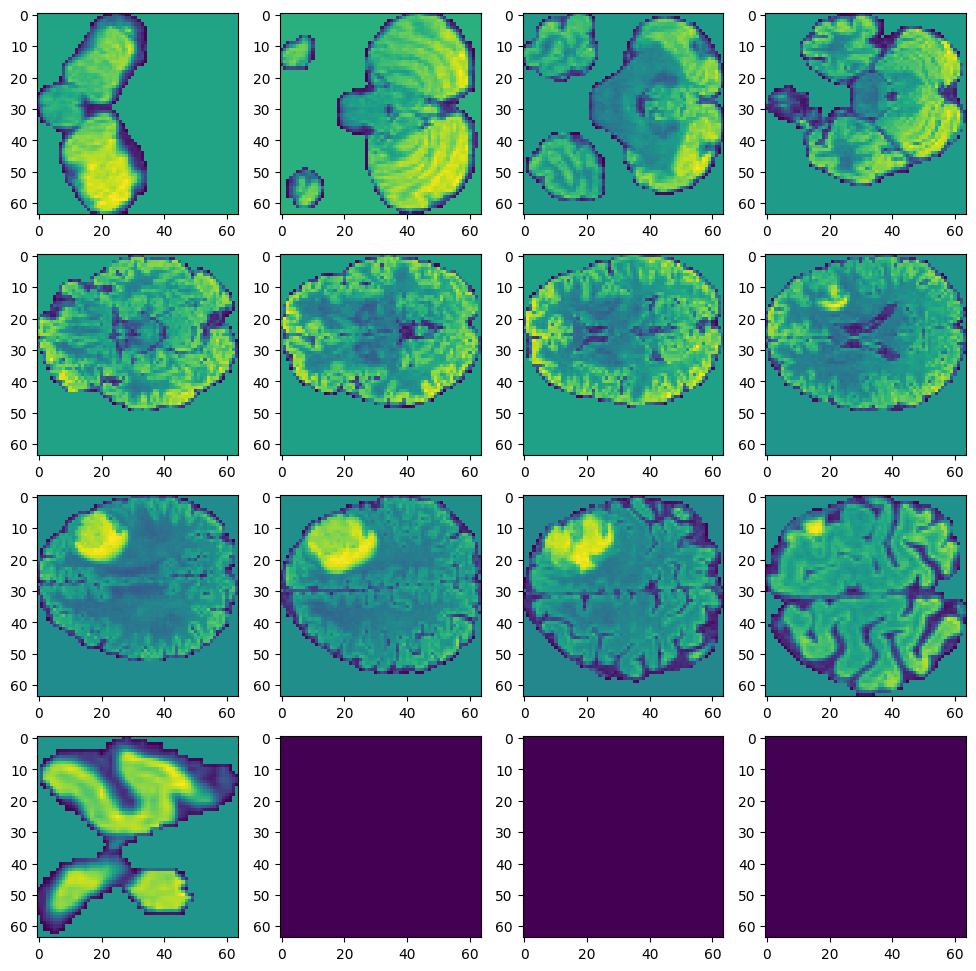

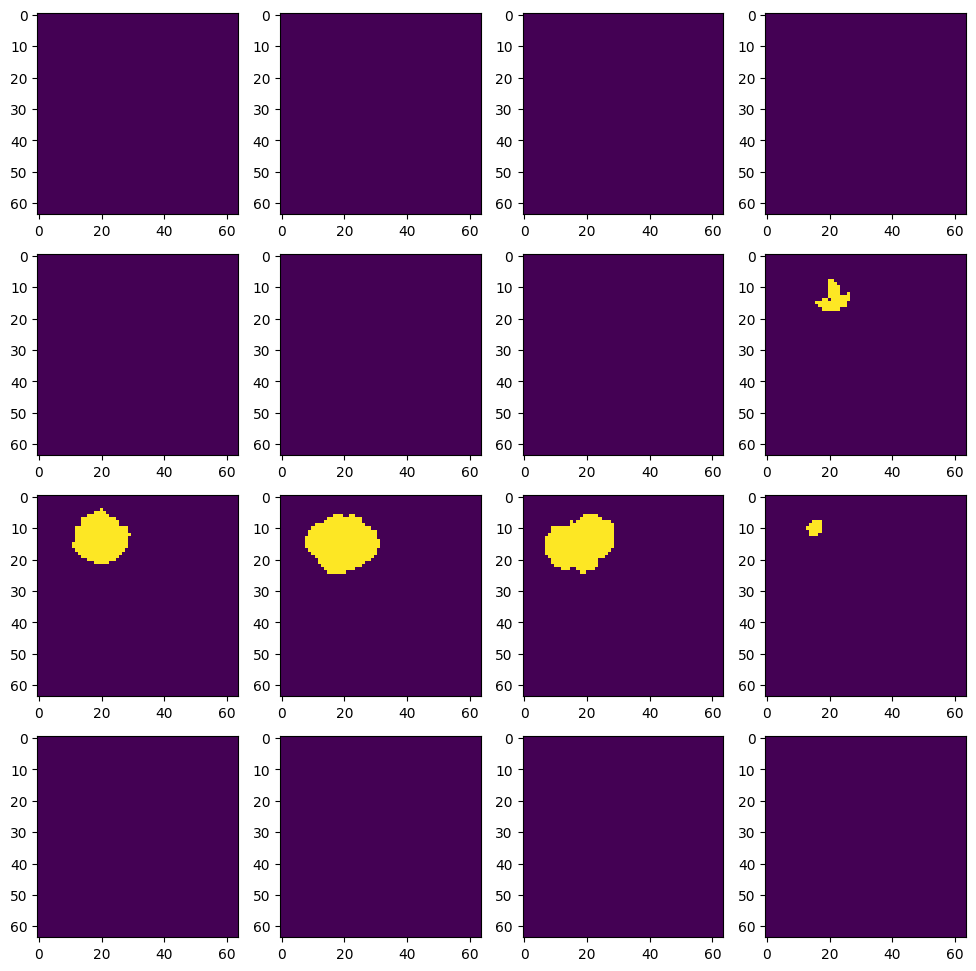

In [8]:
plt.style.use('default')
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(dataset[i * 10][0])
plt.show()
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(dataset[i * 10][1])
plt.show()

In [8]:
# train_val_test_split = [0.7, 0.2, 0.1]

# generator = torch.Generator().manual_seed(SEED)

dataset_size = int(len(dataset)/155)
dataset_indices = list(range(dataset_size))

train_indices, test_indices = train_test_split(dataset_indices, test_size=0.1, random_state=SEED)
train_indices, val_indices = train_test_split(train_indices, test_size=0.22, random_state=SEED)

In [9]:
tmp_list = [[],[],[]]
for i, ind_list in enumerate([train_indices, val_indices, test_indices]):
    for ind in ind_list:
        for j in range(155):
            tmp_list[i].append(ind*155 + j)
train_indices, val_indices, test_indices = tmp_list

In [11]:
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

# Create the subset DataLoader
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

## PyTorch Docs

[nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)

[nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

[nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)

In [12]:
def Conv2d_output(i, p, d, k, s):
    return (i + 2*p - d*(k-1) - 1)/s + 1
def ConvTranspose2d_output(i, p, d, k, s): # p is output_padding
    return (i-1)*s+d*(k-1)+p+1

In [13]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      ## encoder layers ##
      # conv layer (depth from 1 --> 4), 3x3 kernels
      # Input 64 x 64
      nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding = 'same'), # 64 x 64
      nn.ReLU(),
      # pooling layer to reduce x-y dims by two; kernel and stride of 2
      nn.MaxPool2d(2), ## 32 x 32
      # conv layer (depth from 4 --> 8), 4x4 kernels
      nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding = 'same'), # 32 x 32
      nn.ReLU(),
      nn.MaxPool2d(2), # 16 x 16
      # conv layer (depth from 8 --> 12), 5x5 kernels
      nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding = 'same'), # ( 12 x ) 16 x 16
      nn.ReLU(),
      
      ## decoder layers ##
      # add transpose conv layers, with relu activation function
      nn.ConvTranspose2d(12, 6, kernel_size = 2, stride=2), # 32 x 32
      nn.ReLU(),
      nn.ConvTranspose2d(6, 1, kernel_size = 2, stride=2), # 64 x 64
      # output layer (with sigmoid for scaling from 0 to 1)
      # nn.Sigmoid()
    )
    
  def forward(self, x):
    x = x.view(x.shape[0], 1, 64, 64)
    x = self.features(x)
    # x = x.view(x.shape[0], -1)
    # x = torch.flatten(x, start_dim=1)
    return x

In [14]:
model = CNN().to(device)

print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 1,531 trainable parameters.


In [15]:
# Loss
# criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy
# criterion = nn.BCELoss()
criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

# Optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    model,
                                                                    train_dataloader,
                                                                    val_dataloader,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    'CNN.pt')

100.0 % loaded in this epoch
Epoch: 1/1 -- Epoch Time: 17087.09 s
---------------------------------
Train -- Loss: 0.621, Acc: 92.18%
Val -- Loss: 0.458, Acc: 88.14%


In [18]:
model_testing(model, test_dataloader, criterion, device, 'CNN.pt')

Test -- Loss: 0.459, Acc: 88.09 %


In [20]:
labels, pred = predict(model, test_dataloader, device)

In [24]:
print(labels.shape, pred.shape)

torch.Size([19530, 64, 64]) torch.Size([19530, 64, 64])


In [ ]:
print(confusion_matrix(labels, pred))

In [ ]:
print(classification_report(labels, pred))

In [ ]:
# load saved model

model.load_state_dict(torch.load('CNN.pt'))
evaluate(model, test_dataloader, criterion, device)

# Train more epochs

In [26]:
N_EPOCHS = 2

In [28]:
model.load_state_dict(torch.load('CNN.pt'))
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): ConvTranspose2d(12, 6, kernel_size=(2, 2), stride=(2, 2))
    (9): ReLU()
    (10): ConvTranspose2d(6, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)

In [29]:
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    model,
                                                                    train_dataloader,
                                                                    val_dataloader,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    'CNN_2.pt')

100.0 % loaded in this epoch
Epoch: 1/2 -- Epoch Time: 19022.24 s
---------------------------------
Train -- Loss: 0.343, Acc: 95.30%
Val -- Loss: 0.258, Acc: 97.23%
100.0 % loaded in this epoch
Epoch: 2/2 -- Epoch Time: 18103.82 s
---------------------------------
Train -- Loss: 0.207, Acc: 97.33%
Val -- Loss: 0.173, Acc: 97.23%


In [30]:
N_EPOCHS = 1

In [31]:
model.load_state_dict(torch.load('CNN_2.pt'))
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): ConvTranspose2d(12, 6, kernel_size=(2, 2), stride=(2, 2))
    (9): ReLU()
    (10): ConvTranspose2d(6, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)

In [32]:
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    model,
                                                                    train_dataloader,
                                                                    val_dataloader,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    'CNN_3.pt')

100.0 % loaded in this epoch
Epoch: 1/1 -- Epoch Time: 17940.01 s
---------------------------------
Train -- Loss: 0.152, Acc: 97.33%
Val -- Loss: 0.136, Acc: 97.23%


# U-Net

Training
- Crop each image by the size of the tumor
- Resize them (idealy small)
- One hot encoding for each voxel

Model input size
$$(16 \times 16)\times 4\text{ levels of classifications}$$

In [5]:
class Flair(object):
    def __call__(self, sample):
        image, label = sample
        new_image = image[0]
        return new_image, label
    
class IntLabel(object):
    def __call__(self, sample):
        image, label = sample
        new_label = label.astype(int)
        return image, new_label

class CropAndResize(object):
    def __call__(self, sample):
        image, label = sample
        rows = np.any(label, axis=1)
        cols = np.any(label, axis=0)

        # Find the bounding box of the non-zero regions
        rows_indices = np.where(rows)[0]
        cols_indices = np.where(cols)[0]
        if len(rows_indices) != 0 or len(cols_indices) != 0:
            top_row = np.min(rows_indices)
            bottom_row = np.max(rows_indices)
            left_col = np.min(cols_indices)
            right_col = np.max(cols_indices)

            square_size = max(bottom_row - top_row, right_col - left_col) + 1

            # Crop the image
            cropped_image = image[top_row:top_row + square_size, left_col:left_col + square_size]
            cropped_label = label[top_row:top_row + square_size, left_col:left_col + square_size]
        else:
            cropped_image = image
            cropped_label = label
        # Resize the image
        dim = [32,32]
        resized_image = cv2.resize(cropped_image, dim)
        resized_label = cv2.resize(cropped_label, dim)

        return resized_image, resized_label

class Standardise(object) :
    def __call__(self, sample):
        image, label = sample
        if np.abs(image).sum() == 0:
            return image, label
        with np.errstate(divide='ignore',invalid='ignore'):
            image_no_zeros = np.where(image == 0, np.nan, image)
            new_image = (image_no_zeros - np.nanmean(image_no_zeros)) / np.nanstd(image_no_zeros)
            new_image = np.nan_to_num(new_image)
        return new_image, label
    
class OneHotLabel(object):
    def __call__(self, sample):
        image, label = sample
        new_label = np.zeros((32,32,4)) # 0,1,2,4
        for i, l in enumerate([0,1,2,4]):
            new_label[:,:,i] = (label == l)
        return image, new_label

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample
        image = np.float32(image)
        label = np.float32(label)

        # swap channel axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        new_label = label.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(new_label)

In [6]:
dataset = BraTSDataset(image_path = r'./BraTS/BraTS2021_Training_Data',
                                    transform=transforms.Compose([
                                        Flair(),
                                        CropAndResize(),
                                        Standardise(),
                                        IntLabel(),
                                        OneHotLabel(),
                                        ToTensor()
                                    ]))

In [12]:
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

# Create the subset DataLoader
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

In [13]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        ## Input is 32 x 32 x 1
        ## Output is 32 x 32 x 4
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, 4, kernel_size=1)

    def forward(self, x):
        x = x.view(x.shape[0], 1, 32, 32)
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [14]:
model = UNet().to(device)

In [ ]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

In [15]:
# Loss
# criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy
# criterion = nn.BCELoss()
criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

# Optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [49]:
N_EPOCHS = 3

In [50]:
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    model,
                                                                    train_dataloader,
                                                                    val_dataloader,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    'UNet.pt')

100.0 % loaded in this epoch
Epoch: 1/3 -- Epoch Time: 19820.44 s
---------------------------------
Train -- Loss: 0.153, Acc: 94.11%
Val -- Loss: 0.112, Acc: 95.18%
100.0 % loaded in this epoch
Epoch: 2/3 -- Epoch Time: 20267.25 s
---------------------------------
Train -- Loss: 0.105, Acc: 95.61%
Val -- Loss: 0.103, Acc: 95.79%
100.0 % loaded in this epoch
Epoch: 3/3 -- Epoch Time: 21756.53 s
---------------------------------
Train -- Loss: 0.097, Acc: 95.94%
Val -- Loss: 0.098, Acc: 95.99%


In [16]:
N_EPOCHS = 3
model.load_state_dict(torch.load('UNet.pt'))
model.to(device)
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    model,
                                                                    train_dataloader,
                                                                    val_dataloader,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    'UNet2.pt')

100.0 % loaded in this epoch for validation
Epoch: 1/3 -- Epoch Time: 16380.12 s
---------------------------------
Train -- Loss: 0.373, Acc: 91.80%
Val -- Loss: 0.399, Acc: 91.37%
100.0 % loaded in this epoch for validation
Epoch: 2/3 -- Epoch Time: 16032.37 s
---------------------------------
Train -- Loss: 0.383, Acc: 91.70%
Val -- Loss: 0.397, Acc: 91.39%
100.0 % loaded in this epoch for validation
Epoch: 3/3 -- Epoch Time: 16001.27 s
---------------------------------
Train -- Loss: 0.383, Acc: 91.70%
Val -- Loss: 0.398, Acc: 91.38%
